# Looking at KIC 8462852 ([Boyajian's star](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=TYC+3162-665-1)) with [gPhoton](https://archive.stsci.edu/prepds/gphoton/)

Using the time-tagged photon data from GALEX, available with gPhoton, lets make some light curves of "Tabby's Star"

In [48]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from gPhoton import gFind
from gPhoton import gAperture
from gPhoton import gMap
from gPhoton.gphoton_utils import read_lc
import datetime

from astropy.time import Time
from gatspy.periodic import LombScargleFast

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [2]:
ra = 301.5644
dec = 44.45684

## Searching for GALEX visits

Looks like there are 4 visits available in the database

In [3]:
exp_data = gFind(band='NUV', skypos=[ra, dec], exponly=True)

exp_data

NUV: 3311.0s (raw) in 4 exposures.


{'NUV': {'expt': 3311.0,
  'nearest_source': {'distance': 6.5512874478239989e-05,
   'mag': 16.460850000000001,
   'skypos': [301.564352375925, 44.4567839963424]},
  't0': array([  9.93336632e+08,   9.93367098e+08,   9.95690522e+08,
           9.99270098e+08]),
  't1': array([  9.93338307e+08,   9.93367186e+08,   9.95691962e+08,
           9.99270206e+08])}}

... and they seem to be spaced over about 2 months time. 

Alas, not the multi-year coverage I'd hoped for to compare with the results from [Montet & Simon (2016)](https://arxiv.org/abs/1608.01316)

In [8]:
(exp_data['NUV']['t0'] - exp_data['NUV']['t0'][0]) / (60. * 60. * 24. * 365.)

array([ 0.        ,  0.00096607,  0.07464136,  0.18814897])

## Making light curves
Following examples in the [repo](https://github.com/cmillion/gPhoton/tree/master/examples)...

In [9]:
step_size = 10. # the time resolution in seconds

# img_step_size = 30.
# img_size = [0.1, 0.1]
phot_rad = 0.0045 # in deg
ap_in = 0.0050 # in deg
ap_out = 0.0060 # in deg


In [11]:
target = 'KIC8462852'

print(datetime.datetime.now())
for k in range(len(exp_data['NUV']['t0'])):
    photon_events = gAperture(band='NUV', skypos=[ra, dec], stepsz=step_size, radius=phot_rad,
                              annulus=[ap_in, ap_out], verbose=3, csvfile=target+ '_' +str(k)+"_lc.csv",
                              trange=[int(exp_data['NUV']['t0'][k]), int(exp_data['NUV']['t1'][k])+1], 
                              overwrite=True)
    
    print(datetime.datetime.now(), k)

2017-05-24 10:52:14.996286
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [301.5644, 44.45684]
 tranges: [993336631, 993338307]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  10.0
 csvfile: KIC8462852_0_lc.csv
 verbose: 3
[========================================]  2.44Mb / 2.44Mb    
[========================================]  2.44Mb / 2.44Mb    
(datetime.datetime(2017, 5, 24, 10, 54, 31, 440922), 0)                                                                 
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [301.5644, 44.45684]
 tranges: [993367097, 993367186]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  10.0
 csvfile: KIC8462852_1_lc.csv
 verbose: 3
(datetime.datetime(2017, 5, 24, 10, 54, 50, 101551), 1)     84]                                                            
Using v1.28.2 of gAperture.
Generating a light curve with the following paramter

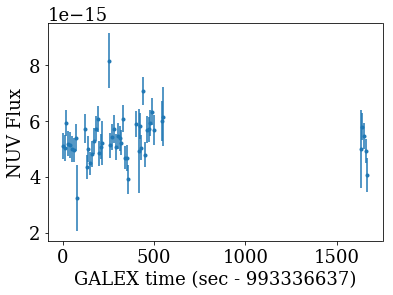

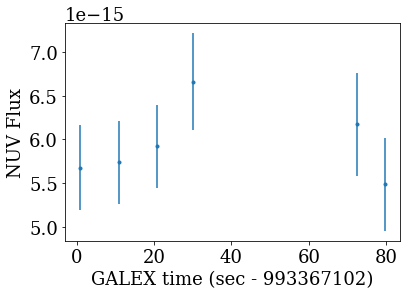

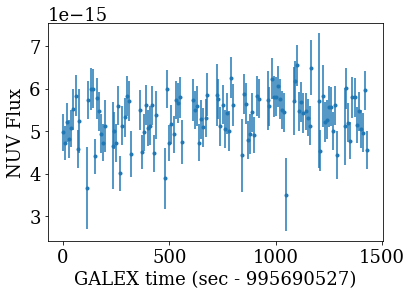

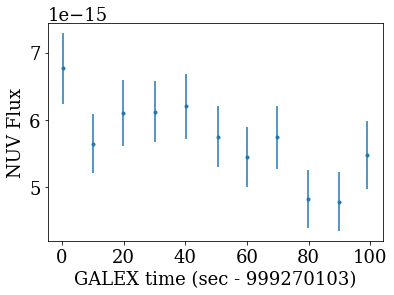

In [39]:
med_flux = np.array(np.zeros(len(exp_data['NUV']['t0'])), dtype='float')
med_flux_err = np.array(np.zeros(len(exp_data['NUV']['t0'])), dtype='float')

time_big = np.array([], dtype='float')
flux_big = np.array([], dtype='float')

for k in range(len(exp_data['NUV']['t0'])):
    data = read_lc(target+ '_' +str(k)+"_lc.csv")
    med_flux[k] = np.nanmedian(data['flux_bgsub'])
    med_flux_err[k] = np.std(data['flux_bgsub'])

    time_big = np.append(time_big, data['t_mean'])
    flux_big = np.append(flux_big, data['flux_bgsub'])
    
    t0k = int(data['t_mean'][0])
    plt.figure()
    plt.errorbar(data['t_mean'] - t0k, data['flux_bgsub'], yerr=data['flux_bgsub_err'], marker='.', linestyle='none')
    plt.xlabel('GALEX time (sec - '+str(t0k)+')')
    plt.ylabel('NUV Flux')
    plt.savefig(target+ '_' +str(k)+"_lc.png", dpi=150, bbox_inches='tight', pad_inches=0.25)
#     plt.close()

**Huh**... that 3rd panel looks like a nice long visit. Let's take a slightly closer look!

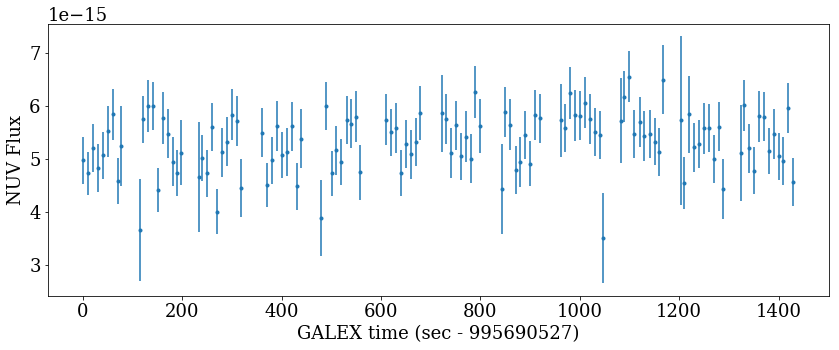

In [38]:
k=2
data = read_lc(target+ '_' +str(k)+"_lc.csv")

t0k = int(data['t_mean'][0])
plt.figure(figsize=(14,5))

plt.errorbar(data['t_mean'] - t0k, data['flux_bgsub'], yerr=data['flux_bgsub_err'], marker='.', linestyle='none')
plt.xlabel('GALEX time (sec - '+str(t0k)+')')
plt.ylabel('NUV Flux')


Any *short* timescale variability of note? Let's use a Lomb-Scargle to make a periodogram!

(limited to the 10sec windowing I imposed... NOTE: gPhoton could easily go shorter, but S/N looks dicey)

Answer: Some interesting structure around 70-80 sec, but nothing super strong

(10, 500)

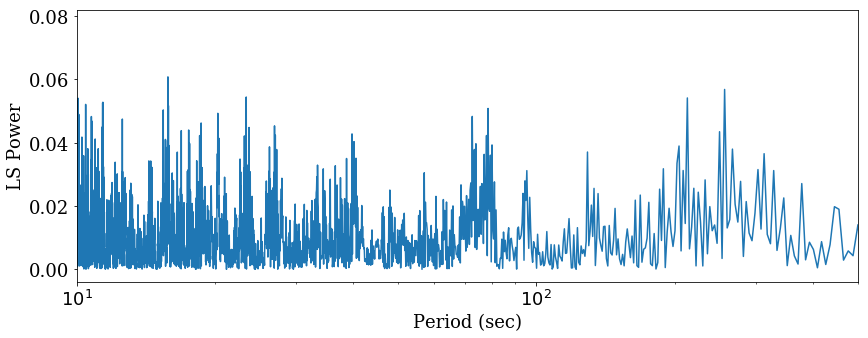

In [64]:
minper = 10 # my windowing
maxper = 10000
nper = 2000
pgram = LombScargleFast(fit_offset=False)
pgram.optimizer.set(period_range=(minper,maxper))

pgram = pgram.fit(time_big - min(time_big), flux_big - np.nanmedian(flux_big))

df = (1./minper - 1./maxper) / nper
f0 = 1./maxper

pwr = pgram.score_frequency_grid(f0, df, nper)

freq = f0 + df * np.arange(nper)
per = 1./freq

##
plt.figure(figsize=(14,5))
plt.plot(per, pwr)
plt.xlabel('Period (sec)')
plt.ylabel('LS Power')
plt.xscale('log')
plt.xlim(10,500)

How about the long-term evolution?

Answer: looks flat!

[ 0.14644732  0.06623611  0.10288624  0.09779896]


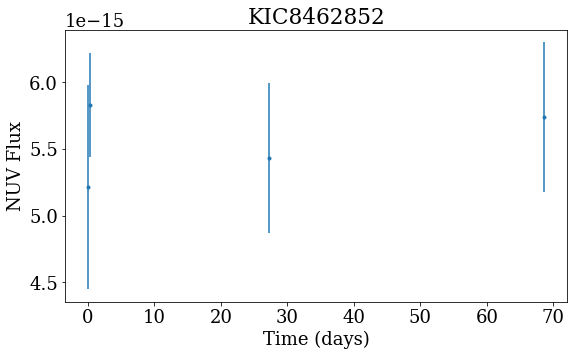

In [47]:
plt.figure(figsize=(9,5))
plt.errorbar((exp_data['NUV']['t0'] - exp_data['NUV']['t0'][0]) / (60.*60.*24.), med_flux, yerr=med_flux_err,
             linestyle='none', marker='.')
plt.xlabel('Time (days)')
plt.ylabel('NUV Flux')
plt.title(target)
plt.savefig(target+'.png', dpi=150, bbox_inches='tight', pad_inches=0.25)


## Conclusion...
Based on data from only 4 GALEX visits, spaced over ~70 days, we can't say much possible evolution of this star with GALEX.

In [46]:
t_unix = Time(exp_data['NUV']['t0'][0] + 315964800, format='unix')
t_date = t_unix.yday
t_date

'2011:179:22:50:31.995'

The visits are centered in mid 2011 (Quarter 9 and 10, I believe)

Note: there was a [special GALEX pointing at the Kepler field](http://galex.stsci.edu/gr6/?page=scanmode) that overlapped with Quarter 14 - approximately 1 year later. This data is not available via gPhoton, but it may be able to be used! The gPhoton data shown here occurs right *before* the "knee" in Figure 3 of [Montet & Simon (2016)](https://arxiv.org/abs/1608.01316), and Quarter 14 is well after. **Therefore a ~3% dip in the flux *should* be observed between this data and the Q14 visit**

However: the per-vist errors shown here (std dev) are around 6-10% for this target. If we co-add it all, we may get enough precision. The Q14 data apparently has 15 total scans... so the measurment may be borderline possible!